In [3]:
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Load data and rename columns
df = pd.read_csv("tsp.csv")
df.columns = ['lat', 'lon', 'city', 'extra']
df.drop(columns=['extra'], inplace=True)
print(df.head())

# Target location
target_lat, target_lon = 16.1067, 80.8326


def objective_function(position):
    return np.sqrt((position[0] - target_lat) ** 2 + (position[1] - target_lon) ** 2)


#Particle Swarm Optimization algorithm
# start
class Particle:
    def __init__(self, x, y):
        self.position = np.array([x, y])
        self.velocity = np.array([random.uniform(-1, 1), random.uniform(-1, 1)])
        self.best_position = self.position
        self.best_value = float('inf')

    def update_velocity(self, global_best_position, w=0.5, c1=1, c2=2):
        r1 = random.random()
        r2 = random.random()
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best_position - self.position)
        self.velocity = w * self.velocity + cognitive + social

    def update_position(self):
        self.position = self.position + self.velocity


# Initialize particles
particles = [Particle(x, y) for x, y in zip(df['lat'], df['lon'])]
global_best_value = float('inf')
global_best_position = np.array([0, 0])

# PSO loop
for _ in range(100):  # Number of iterations
    for particle in particles:
        value = objective_function(particle.position)
        if value < particle.best_value:
            particle.best_value = value
            particle.best_position = particle.position

        if value < global_best_value:
            global_best_value = value
            global_best_position = particle.position

    for particle in particles:
        particle.update_velocity(global_best_position)
        particle.update_position()

print("\nPSO Algo: ")
print("Best global position:", global_best_position)
print("Best global value:", global_best_value)

# end of PSO


# Fitness function: calculates Euclidean distance from the target location
def fitness(individual):
    return np.sqrt((individual['lat'] - target_lat) ** 2 + (individual['lon'] - target_lon) ** 2)

#Genetic Algorithm
# start
# Selection: Tournament selection method
def selection(population, fitness, k=3):
    tournament = random.sample(population, k)
    return min(tournament, key=fitness)


# Crossover: Single-point crossover
def crossover(parent1, parent2):
    child = parent1.copy()
    if random.random() < 0.5:
        child['lat'] = parent2['lat']
    if random.random() < 0.5:
        child['lon'] = parent2['lon']
    return child


# Mutation: Small random change
def mutate(individual, mutation_rate=0.1):
    if random.random() < mutation_rate:
        individual['lat'] += random.uniform(-0.1, 0.1)
    if random.random() < mutation_rate:
        individual['lon'] += random.uniform(-0.1, 0.1)


# Genetic Algorithm Parameters
population_size = 20
generations = 100
mutation_rate = 0.1

# Initialize population
population = df.sample(n=population_size).to_dict('records')

# Evolutionary loop
for generation in range(generations):
    new_population = []
    for _ in range(population_size):
        # Selection
        parent1 = selection(population, fitness)
        parent2 = selection(population, fitness)
        # Crossover
        child = crossover(parent1, parent2)
        # Mutation
        mutate(child, mutation_rate)
        new_population.append(child)
    # Elitism: Keep the best individual
    best_individual = min(population, key=fitness)
    population = sorted(new_population, key=fitness)[:population_size - 1]
    population.append(best_individual)

# Best solution
best_solution = min(population, key=fitness)
print()
print("Genetic Algo: ")
print("Best Solution:", best_solution)
# end of GA


# Start of DE
# Differential Evolution parameters
population_size = 10
mutation_factor = 0.8
crossover_rate = 0.7
generations = 100

# Initialize population
population = [np.array([x, y]) for x, y in zip(df['lat'], df['lon'])]
population = random.sample(population, population_size)

# Evolution loop
for generation in range(generations):
    new_population = []
    for i in range(population_size):
        # Ensure indices are unique
        indices = [index for index in range(population_size) if index != i]
        a_idx, b_idx, c_idx = random.sample(indices, 3)
        a, b, c = population[a_idx], population[b_idx], population[c_idx]

        # Mutation
        mutant_vector = a + mutation_factor * (b - c)

        # Crossover
        crossover_vector = np.array([
            mutant_vector[j] if random.random() < crossover_rate else population[i][j]
            for j in range(len(mutant_vector))
        ])

        # Selection
        if objective_function(crossover_vector) < objective_function(population[i]):
            new_population.append(crossover_vector)
        else:
            new_population.append(population[i])

    # Update population
    population = new_population

# Find the best solution
best_solution = min(population, key=objective_function)
best_value = objective_function(best_solution)

print("\nDE algo:")
print("Best solution:", best_solution)
print("Best value:", best_value)

#end of DE

#  Bayesian ALgo
# Utility function: Expected Improvement
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    sigma = sigma.reshape(-1, 1)
    mu_sample_opt = np.min(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu_sample_opt - mu - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


# Acquisition function
def propose_location(X_sample, Y_sample, gpr, bounds, n_restarts=10):
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        return -expected_improvement(X.reshape(-1, dim), X_sample, Y_sample, gpr)

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x


# Initialize sample points and observations
X_sample = df[['lat', 'lon']].values
Y_sample = np.array([objective_function(x) for x in X_sample]).reshape(-1, 1)

# Define the bounds (latitude and longitude)
bounds = np.array([[df['lat'].min(), df['lat'].max()],
                   [df['lon'].min(), df['lon'].max()]])

# Gaussian Process with Matern kernel
kernel = Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

# Perform Bayesian Optimization
n_iter = 10
for i in range(n_iter):
    gpr.fit(X_sample, Y_sample)

    # Propose the next location to evaluate
    next_sample = propose_location(X_sample, Y_sample, gpr, bounds)
    next_sample = next_sample.reshape(1, -1)

    # Obtain the objective function value for the proposed sample
    next_value = objective_function(next_sample[0])

    # Update samples
    X_sample = np.vstack((X_sample, next_sample))
    Y_sample = np.vstack((Y_sample, next_value))

# Best solution found
best_index = np.argmin(Y_sample)
best_solution = X_sample[best_index]
best_value = Y_sample[best_index]

print("\nBayesian algo: ")
print("Best solution:", best_solution)
print("Best value:", best_value)



       lat      lon          city
0  16.5500  80.6167     Amaravati
1  14.6819  77.5995     Anantapur
2  13.2239  79.1995   Chandragiri
3  13.2166  79.1667      Chittoor
4  16.9983  81.7833  Dowlaiswaram

PSO Algo: 
Best global position: [16.1067 80.8326]
Best global value: 1.7763568394002505e-14

Genetic Algo: 
Best Solution: {'lat': 16.10696943778401, 'lon': 80.8317220330579, 'city': 'Vijayawada'}

DE algo:
Best solution: [16.10670006 80.83259987]
Best value: 1.3974055118765752e-07

Bayesian algo: 
Best solution: [16.1846 81.148 ]
Best value: [0.32487778]


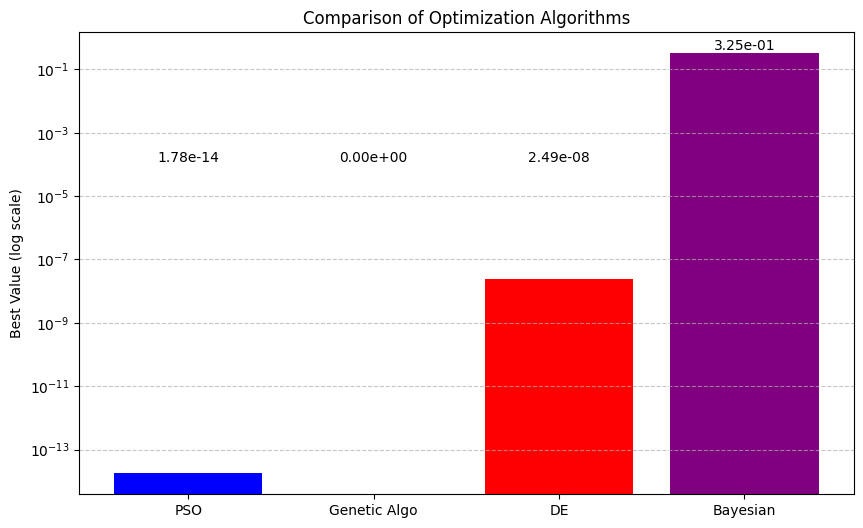

In [4]:
import matplotlib.pyplot as plt

# Data points for each algorithm
algorithms = ["PSO", "Genetic Algo", "DE", "Bayesian"]
best_values = [1.7763568394002505e-14, 0, 2.4863234563906336e-08, 0.32487778]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(algorithms, best_values, color=['blue', 'green', 'red', 'purple'])
plt.yscale('log')  # Use logarithmic scale for better comparison
plt.ylabel('Best Value (log scale)')
plt.title('Comparison of Optimization Algorithms')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotating the best values on the bars
for i, v in enumerate(best_values):
    plt.text(i, v + 0.0001, f'{v:.2e}', ha='center', va='bottom')

plt.show()


C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training L1 Regularization...
Training L2 Regularization...
Training Dropout...
Training Batch Normalization...
Training L1 + Dropout...
Training L2 + Dropout...
Training Batch Norm + Dropout...


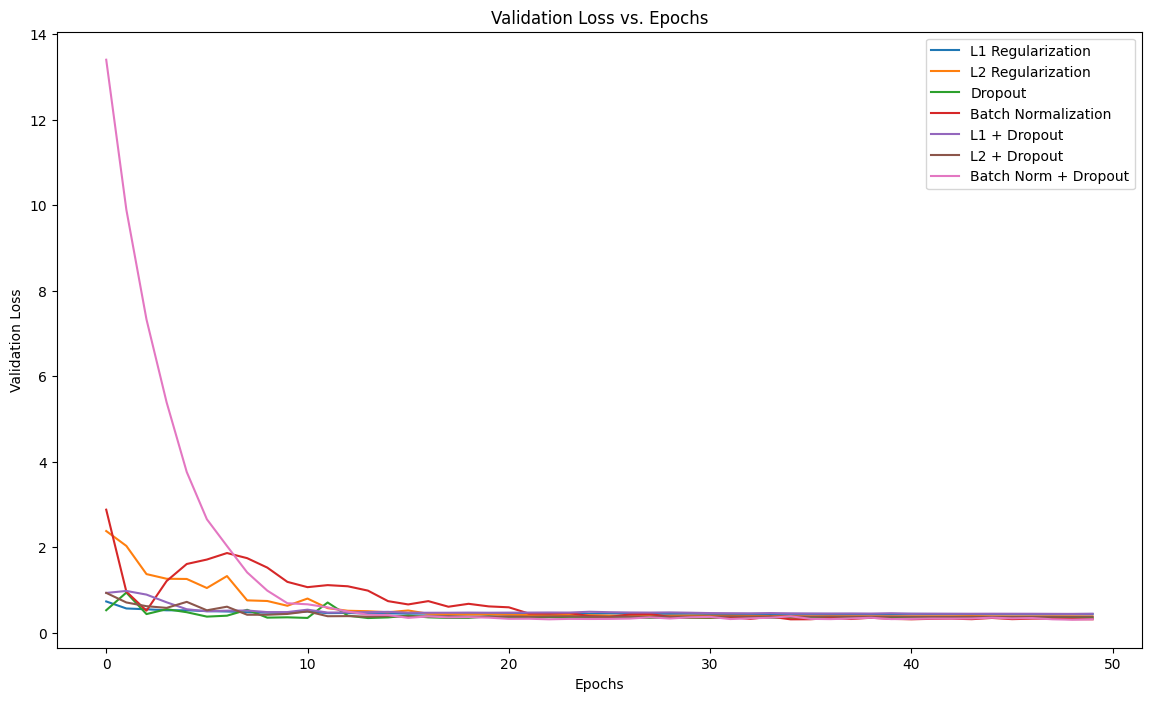

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Load dataset
df = pd.read_csv('tsp.csv')
df.columns = ['lat', 'lon', 'city', 'extra']
df.drop(columns=['extra'], inplace=True)

# Generate synthetic binary target based on distance from target location
target_lat, target_lon = 16.1067, 80.8326
df['distance'] = np.sqrt((df['lat'] - target_lat) ** 2 + (df['lon'] - target_lon) ** 2)
df['target'] = (df['distance'] < df['distance'].median()).astype(int)

# Prepare input and target variables
X = df[['lat', 'lon']]
y = df['target']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to create a model
def create_model(regularization=None, dropout_rate=0, batch_norm=False):
    model = Sequential()
    if regularization:
        model.add(Dense(64, input_dim=2, activation='relu', kernel_regularizer=regularization))
    else:
        model.add(Dense(64, input_dim=2, activation='relu'))
    if batch_norm:
        model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train models with different regularization techniques
models = {
    "L1 Regularization": create_model(regularization='l1', dropout_rate=0.5),
    "L2 Regularization": create_model(regularization='l2', dropout_rate=0.5),
    "Dropout": create_model(dropout_rate=0.5),
    "Batch Normalization": create_model(batch_norm=True),
    "L1 + Dropout": create_model(regularization='l1', dropout_rate=0.5),
    "L2 + Dropout": create_model(regularization='l2', dropout_rate=0.5),
    "Batch Norm + Dropout": create_model(batch_norm=True, dropout_rate=0.5),
}

history = {}
for name, model in models.items():
    print(f"Training {name}...")
    history[name] = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

# Plot the results
plt.figure(figsize=(14, 8))
for name, hist in history.items():
    plt.plot(hist.history['val_loss'], label=name)

plt.title('Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()
